In [1]:
import pandas as pd
import glob
import os


In [14]:

FOLDER_PATH =  "/home/exouser/Downloads/cvsbehavior100"  

daily_summaries = []

for file in sorted(os.listdir(FOLDER_PATH)):
    if file.endswith(".csv") and file.startswith("behavior_act"):
        date_str = file.split("behavior_act")[1].split(".csv")[0]
        df = pd.read_csv(os.path.join(FOLDER_PATH, file))

        if "cow_id" not in df.columns or "behavior_id" not in df.columns:
            continue  # Salta archivos mal formateados
            
        # Conteo por vaca y comportamiento
        summary = df.groupby(["cow_id", "behavior_id"]).size().unstack(fill_value=0).reset_index()
        summary.columns.name = None  # ✅ Elimina 'behavior_id' como nombre de columna
        summary["date"] = date_str
        daily_summaries.append(summary)


# Une todos los días
if daily_summaries:
    final_df = pd.concat(daily_summaries, ignore_index=True)

    # Ordena columnas (opcional)
    behavior_cols = sorted([col for col in final_df.columns if isinstance(col, int)])  # columnas de behaviors
    final_df = final_df[["cow_id", "date"] + behavior_cols]

    # Renombra columnas si quieres (ej. 1 → behavior_1)
    final_df = final_df.rename(columns={bid: f"behavior_{bid}" for bid in behavior_cols})

    print("✅ DataFrame final listo")
    print(final_df.head())
else:
    print("⚠️ No se encontraron archivos válidos")
    final_df = pd.DataFrame()


✅ DataFrame final listo
   cow_id  date  behavior_0  behavior_1  behavior_2  behavior_3  behavior_4  \
0       0  0721           1          73          13          29           0   
1       1  0721           0          62          10          24           1   
2       2  0721           0          75          12          24           1   
3       3  0721           0         115          23          29           0   
4       4  0721           0          48          49          25           0   

   behavior_5  behavior_6  
0           4           0  
1           3         123  
2           0           3  
3           3           4  
4           4          42  


In [15]:
# Guarda el archivo final
final_df.to_csv("behavior_summary100.csv", index=False)
print(f"✅ Archivo generado: {OUTPUT_CSV}")

✅ Archivo generado: behavior_summary.csv


In [ ]:
# Normalize

In [24]:
def normalize_behavior_counts_overwrite(df):
    """
    Returns a new DataFrame where behavior counts are normalized by the total per cow per day.
    The original behavior columns are replaced by their normalized values.
    """
    behavior_cols = [col for col in df.columns if col.startswith("behavior_")]

    # Calcula total de observaciones por fila (por vaca y día)
    df_copy = df.copy()
    df_copy["total_behaviors"] = df_copy[behavior_cols].sum(axis=1)

    # Normaliza y reemplaza los valores originales
    for col in behavior_cols:
        df_copy[col] = df_copy[col] / df_copy["total_behaviors"]

    # Elimina la columna auxiliar
    df_copy.drop(columns=["total_behaviors"], inplace=True)

    return df_copy


In [25]:
normalized_df = normalize_behavior_counts_overwrite(final_df)
print(normalized_df.head())



   cow_id  date  behavior_0  behavior_1  behavior_2  behavior_3  behavior_4  \
0       0  0721    0.008333    0.608333    0.108333    0.241667    0.000000   
1       1  0721    0.000000    0.278027    0.044843    0.107623    0.004484   
2       2  0721    0.000000    0.652174    0.104348    0.208696    0.008696   
3       3  0721    0.000000    0.660920    0.132184    0.166667    0.000000   
4       4  0721    0.000000    0.285714    0.291667    0.148810    0.000000   

   behavior_5  behavior_6  
0    0.033333    0.000000  
1    0.013453    0.551570  
2    0.000000    0.026087  
3    0.017241    0.022989  
4    0.023810    0.250000  


In [26]:
normalized_df.to_csv("behavior_summary100N.csv", index=False)

In [31]:
def count_total_records_per_day(df):
    """
    Returns a DataFrame with the total number of behavior records per day (summed across all cows).
    """
    behavior_cols = [col for col in df.columns if col.startswith("behavior_")]
    
    df_copy = df.copy()
    df_copy["total_records"] = df_copy[behavior_cols].sum(axis=1)

    total_per_day = df_copy.groupby("date")["total_records"].sum().reset_index()
    total_per_day.columns = ["date", "total_records_all_cows"]
    
    return total_per_day



In [32]:
total_daily_records = count_total_records_per_day(final_df)
print(total_daily_records)




    date  total_records_all_cows
0   0721                    2916
1   0722                    5435
2   0723                    5354
3   0724                    5553
4   0725                    5806
5   0726                    5355
6   0727                    5548
7   0728                    5521
8   0729                    4902
9   0730                    4887
10  0731                    5194
11  0801                    5258
12  0802                    5567
13  0803                    5577
14  0804                     927


# WITHOUT NORMALIZE

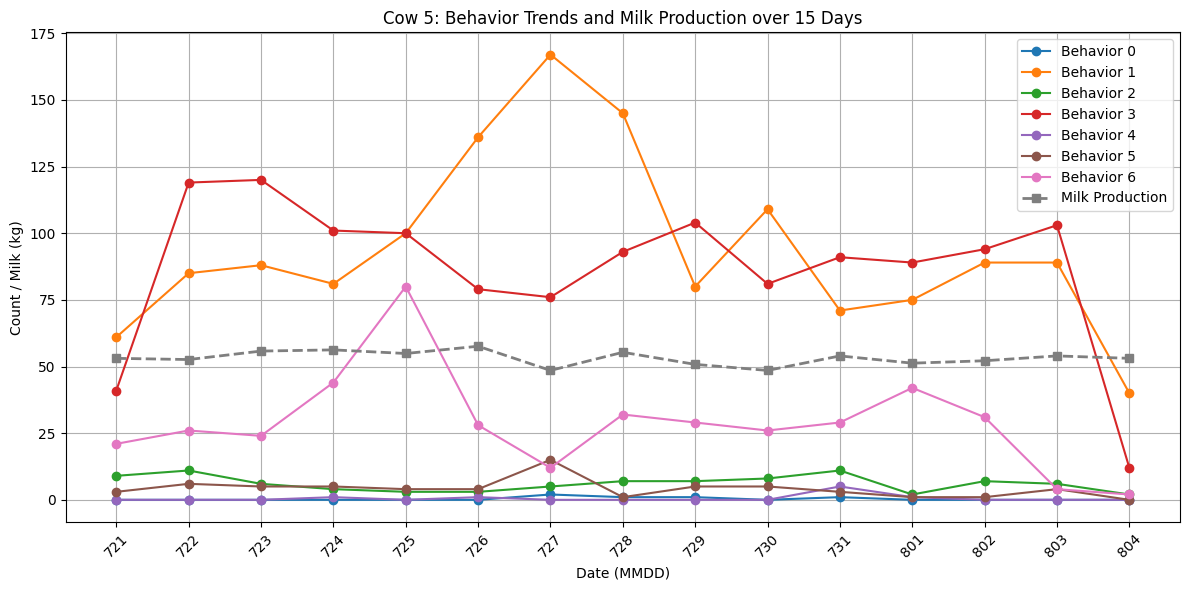

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("togetheer.csv")

# Filter data for cow_id 5
df_cow5 = df[df['cow_id'] == 5]

# Sort by date to ensure correct plotting
df_cow5 = df_cow5.sort_values(by='date')

# Set the date as x-axis
x = df_cow5['date'].astype(str)  # convert to string for better x-axis labels

# Plot
plt.figure(figsize=(12, 6))

# Plot each behavior (assuming columns are named 'behavior_0', 'behavior_1', ..., 'behavior_6')
for i in range(7):
    plt.plot(x, df_cow5[f'behavior_{i}'], label=f'Behavior {i}', marker='o')

# Plot milk production
plt.plot(x, df_cow5['milk_weight'], label='Milk Production', marker='s', linewidth=2, linestyle='--')

plt.title('Cow 5: Behavior Trends and Milk Production over 15 Days')
plt.xlabel('Date (MMDD)')
plt.ylabel('Count / Milk (kg)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


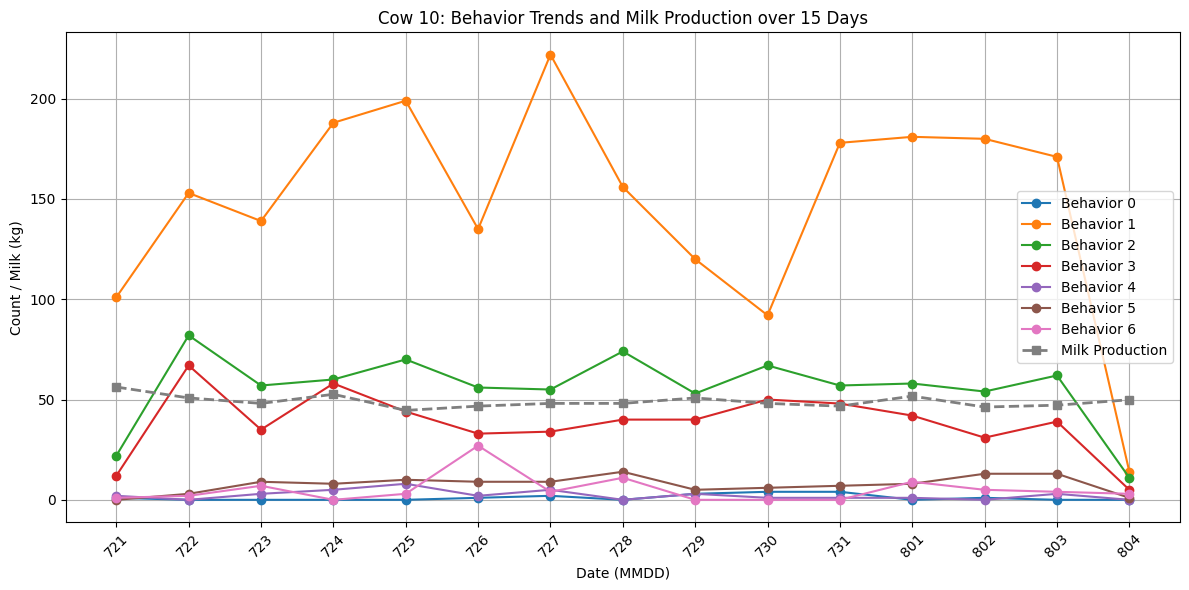

In [20]:

# Load the CSV
df = pd.read_csv("togetheer.csv")

# Filter data for cow_id 10
df_cow10 = df[df['cow_id'] == 10]

# Sort by date to ensure correct plotting
df_cow10 = df_cow10.sort_values(by='date')

# Set the date as x-axis
x = df_cow10['date'].astype(str)  # convert to string for better x-axis labels

# Plot
plt.figure(figsize=(12, 6))

# Plot each behavior (assuming columns are named 'behavior_0', 'behavior_1', ..., 'behavior_6')
for i in range(7):
    plt.plot(x, df_cow10[f'behavior_{i}'], label=f'Behavior {i}', marker='o')

# Plot milk production
plt.plot(x, df_cow10['milk_weight'], label='Milk Production', marker='s', linewidth=2, linestyle='--')

plt.title('Cow 10: Behavior Trends and Milk Production over 15 Days')
plt.xlabel('Date (MMDD)')
plt.ylabel('Count / Milk (kg)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


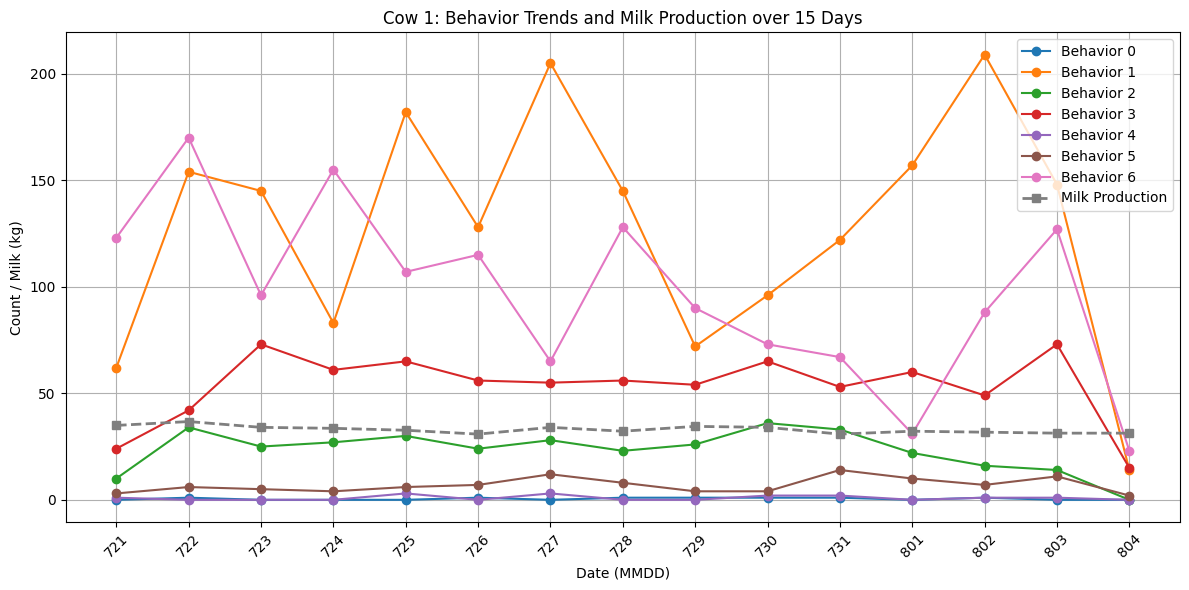

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("togetheer.csv")

# Filter data for cow_id 10
df_cow1 = df[df['cow_id'] == 1]

# Sort by date to ensure correct plotting
df_cow1 = df_cow1.sort_values(by='date')

# Set the date as x-axis
x = df_cow1['date'].astype(str)  # convert to string for better x-axis labels

# Plot
plt.figure(figsize=(12, 6))

# Plot each behavior (assuming columns are named 'behavior_0', 'behavior_1', ..., 'behavior_6')
for i in range(7):
    plt.plot(x, df_cow1[f'behavior_{i}'], label=f'Behavior {i}', marker='o')

# Plot milk production
plt.plot(x, df_cow1['milk_weight'], label='Milk Production', marker='s', linewidth=2, linestyle='--')

plt.title('Cow 1: Behavior Trends and Milk Production over 15 Days')
plt.xlabel('Date (MMDD)')
plt.ylabel('Count / Milk (kg)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
